In [1]:
#
# Copyright (c) 2024, NVIDIA CORPORATION. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

### Check the TensorRT version

In [2]:
!python3 -c 'import tensorrt; print("TensorRT version: {}".format(tensorrt.__version__))'

TensorRT version: 10.2.0.post1


### Prepare the input image and ONNX model file

In [3]:
!python3 export.py

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.0.7) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
Exporting ppm image input.ppm
Using cache found in /home/simengl/.cache/torch/hub/pytorch_vision_v0.6.0
Exporting ONNX model fcn-resnet101.onnx


### Build TensorRT engine from the ONNX model

In [4]:
!trtexec --onnx=fcn-resnet101.onnx --saveEngine=fcn-resnet101.engine --optShapes=input:1x3x1026x1282

### Import required modules

In [5]:
import numpy as np
import os
import pycuda.driver as cuda
import pycuda.autoinit
import tensorrt as trt

import matplotlib.pyplot as plt
from PIL import Image

TRT_LOGGER = trt.Logger()

# Filenames of TensorRT plan file and input/output images.
engine_file = "fcn-resnet101.engine"
input_file  = "input.ppm"
output_file = "output.ppm"

### Utilities for input / output processing

In [6]:
# For torchvision models, input images are loaded in to a range of [0, 1] and
# normalized using mean = [0.485, 0.456, 0.406] and stddev = [0.229, 0.224, 0.225].
def preprocess(image):
    # Mean normalization
    mean = np.array([0.485, 0.456, 0.406]).astype('float32')
    stddev = np.array([0.229, 0.224, 0.225]).astype('float32')
    data = (np.asarray(image).astype('float32') / float(255.0) - mean) / stddev
    # Switch from HWC to to CHW order
    return np.moveaxis(data, 2, 0)

def postprocess(data):
    num_classes = 21
    # create a color palette, selecting a color for each class
    palette = np.array([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
    colors = np.array([palette*i%255 for i in range(num_classes)]).astype("uint8")
    # plot the segmentation predictions for 21 classes in different colors
    img = Image.fromarray(data.astype('uint8'), mode='P')
    img.putpalette(colors)
    return img


### Load TensorRT engine

Deserialize the TensorRT engine from specified plan file. 

In [7]:
def load_engine(engine_file_path):
    assert os.path.exists(engine_file_path)
    print("Reading engine from file {}".format(engine_file_path))
    with open(engine_file_path, "rb") as f, trt.Runtime(TRT_LOGGER) as runtime:
        return runtime.deserialize_cuda_engine(f.read())

### Inference pipeline

Starting with a deserialized engine, TensorRT inference pipeline consists of the following steps:
- Create an execution context and specify input shape (based on the image dimensions for inference).
- Allocate CUDA device memory for input and output.
- Allocate CUDA page-locked host memory to efficiently copy back the output.
- Transfer the processed image data into input memory using asynchronous host-to-device CUDA copy.
- Kickoff the TensorRT inference pipeline using the asynchronous execute API.
- Transfer the segmentation output back into pagelocked host memory using device-to-host CUDA copy.
- Synchronize the stream used for data transfers and inference execution to ensure all operations are completes.
- Finally, write out the segmentation output to an image file for visualization.

In [8]:
def infer(engine, input_file, output_file):
    print("Reading input image from file {}".format(input_file))
    with Image.open(input_file) as img:
        input_image = preprocess(img)
        image_width = img.width
        image_height = img.height

    with engine.create_execution_context() as context:
        # Allocate host and device buffers
        tensor_names = [engine.get_tensor_name(i) for i in range(engine.num_io_tensors)]
        for tensor in tensor_names:
            size = trt.volume(context.get_tensor_shape(tensor))
            dtype = trt.nptype(engine.get_tensor_dtype(tensor))
            
            if engine.get_tensor_mode(tensor) == trt.TensorIOMode.INPUT:
                context.set_input_shape(tensor, (1, 3, image_height, image_width))
                input_buffer = np.ascontiguousarray(input_image)
                input_memory = cuda.mem_alloc(input_image.nbytes)
                context.set_tensor_address(tensor, int(input_memory))
            else:
                output_buffer = cuda.pagelocked_empty(size, dtype)
                output_memory = cuda.mem_alloc(output_buffer.nbytes)
                context.set_tensor_address(tensor, int(output_memory))

        stream = cuda.Stream()
        
        # Transfer input data to the GPU.
        cuda.memcpy_htod_async(input_memory, input_buffer, stream)
        
        # Run inference
        context.execute_async_v3(stream_handle=stream.handle)
        
        # Transfer prediction output from the GPU.
        cuda.memcpy_dtoh_async(output_buffer, output_memory, stream)
        
        # Synchronize the stream
        stream.synchronize()
        output_d64 = np.array(output_buffer, dtype=np.int64)
        np.savetxt('test.out', output_d64.astype(int), fmt='%i', delimiter=' ', newline=' ')

    with postprocess(np.reshape(output_buffer, (image_height, image_width))) as img:
        print("Writing output image to file {}".format(output_file))
        img.convert('RGB').save(output_file, "PPM")

### Plot input image

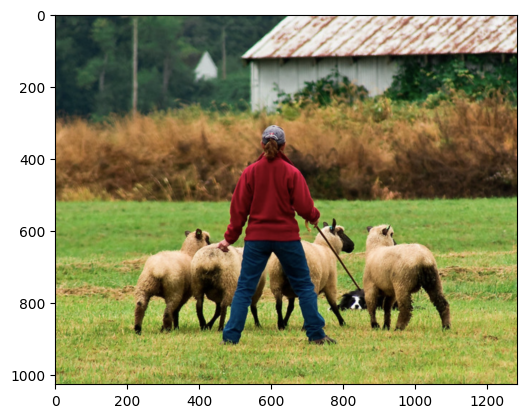

In [9]:
plt.imshow(Image.open(input_file))

### Run inference

In [10]:
print("Running TensorRT inference for FCN-ResNet101")
with load_engine(engine_file) as engine:
    infer(engine, input_file, output_file)

Running TensorRT inference for FCN-ResNet101
Reading engine from file fcn-resnet101.engine


[07/31/2024-12:07:11] [TRT] [W] Using an engine plan file across different models of devices is not recommended and is likely to affect performance or even cause errors.
Reading input image from file input.ppm
Writing output image to file output.ppm


### Plot segmentation output

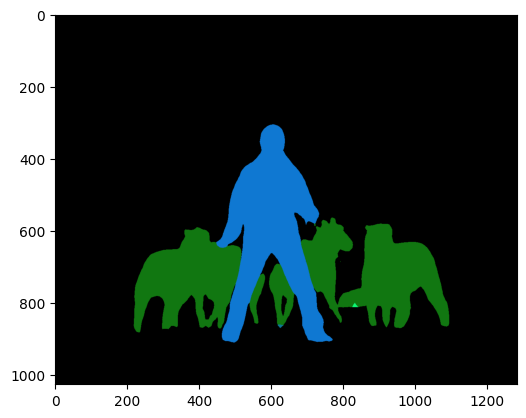

In [11]:
plt.imshow(Image.open(output_file))